In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os
from scipy.optimize import curve_fit
import B00_codes.dataReader as dr
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import math
import json
import matplotlib.colors as mcolors

NO_MS_EQUALS_1 = 0
Q_FINAL = 1
THREE_PI_HALF_FINAL = 2
REF_MINUS_SIG  =3

def running_average(arr):
    running_sum = 0
    running_avg = []

    for i, num in enumerate(arr):
        running_sum += num
        avg = running_sum / (i + 1)  # Calculate the running average
        running_avg.append(avg)

    return running_avg

def smooth(x, n=3):
    K = int((n-1)/2)
    smoothed_x = np.zeros(len(x))
    for i in range(K):
        smoothed_x[i] = x[i]
        smoothed_x[-i-1] = x[-i-1]
    for i in range(0, len(x)-(n-1)):
        for j in range(n):
            smoothed_x[i+K] += x[i+j]/n
    return smoothed_x

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

def average(y, n):
    # Initialize an empty list to store the averages
    averages = []

    # Iterate through the array in steps of 3
    for i in range(0, len(y), n):
        group = y[i:i + n]  # Get a group of three points
        average = np.mean(group)  # Calculate the average of the group
        averages.append(average)  # Add the average to the list

    # Convert the list of averages back to a NumPy array
    return np.array(averages)
pi = np.pi

In [ ]:
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-10-31/#013_CalibReadoutPhotonStat_02-13-07/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-10-31/#154_CalibReadoutPhotonStat_06-36-03/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-10-31/#200_CalibReadoutPhotonStat_12-15-04/CalibReadoutPhotonStatObject_sig_set.dat'

sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
    dataFilename, num_of_bins=1, plot_hist_every=5, binwidth=1)

In [101]:
# Repeat measuring photon stats
days = np.linspace(31,31, 1)
dataArr = []; gArr = []; err_gArr = []; sigAvgs = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-10-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'PhotonStat' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 294 and idx <= 816:
                datafile = mainFolder + dataFolder +'/CalibReadoutPhotonStatObject_sig_set.dat'
                current = 65

                sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
                                    datafile, num_of_bins=50, binwidth=1, plot_hist_every=100, ifPlot=False,
                                    ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=False,)
                sigAvg = np.average(sig,1)
                if sigAvgs is None: sigAvgs = sigAvg
                else: sigAvgs = np.vstack((sigAvgs, sigAvg))
                

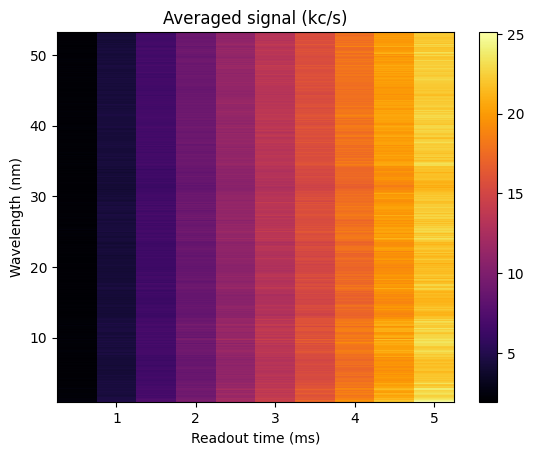

In [103]:
fig,ax = plt.subplots()
xplot = yplot/1e6    # yplot is already readout time in ns
# yplot = np.linspace(636.5,637.13,63)
yplot = np.arange(1, 1+0.1*523, 0.1)
Xplot, Yplot = np.meshgrid(xplot,yplot)
plot = ax.pcolormesh(Xplot, Yplot, sigAvgs, cmap='inferno')
ax.set_xlabel(r"Readout time (ms)")
ax.set_ylabel(r"Wavelength (nm)")
ax.set_title("Averaged signal (kc/s)")
fig.colorbar(plot, orientation='vertical')

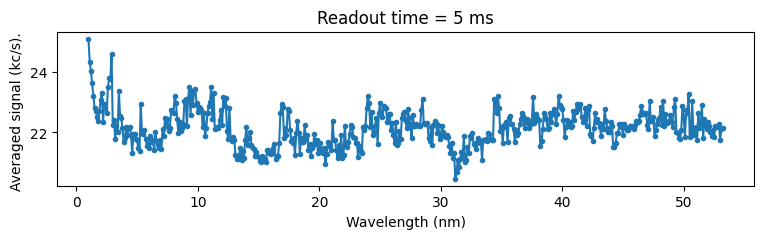

In [105]:
fig,ax = plt.subplots(figsize=(9,2))
time_idx = -1
ax.plot(yplot, sigAvgs[:,time_idx],  'o-', markersize=3, )
ax.set_ylabel(r"Averaged signal (kc/s). ")
ax.set_xlabel(r"Wavelength (nm)")
ax.set_title("Readout time = %.0f ms" % xplot[time_idx]);

# Find optical resonant

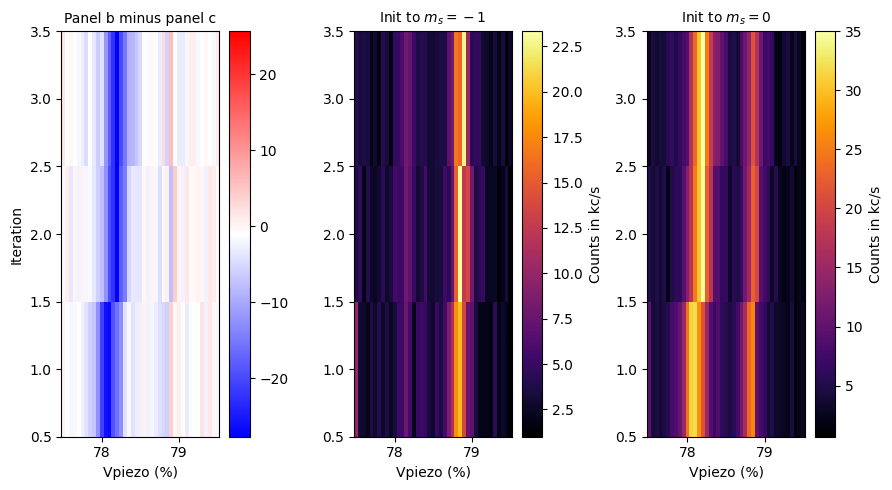

In [403]:
# ODMR
days = np.linspace(13,13,1)
dataArr = []; sigArr = []; refArr = []; idxs = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanROFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (idx >= 959 and idx <= 1325 and np.mod(idx,2)==1):
            if (idx >= 1127 and idx <= 1189):
                datafile = mainFolder + dataFolder +'/ScanROFreqObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig-ref
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)

sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]
sigArr = sigArr[sorted_indices]
refArr = refArr[sorted_indices]

# Create a colormap with the custom midpoint
cmap = plt.get_cmap('bwr')  # You can choose any colormap
norm = mcolors.CenteredNorm(vcenter=-1)

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap=cmap, norm=norm)
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('Vpiezo (%)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('Panel b minus panel c',fontsize=10)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('Vpiezo (%)')
axs[1].set_title('Init to $m_s = -1$',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('Vpiezo (%)')
axs[2].set_title('Init to $m_s = 0$',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

# for i in range(3):
#     axs[i].set_xlim((60,90))
#     # axs[i].set_ylim((0,175))

plt.tight_layout()

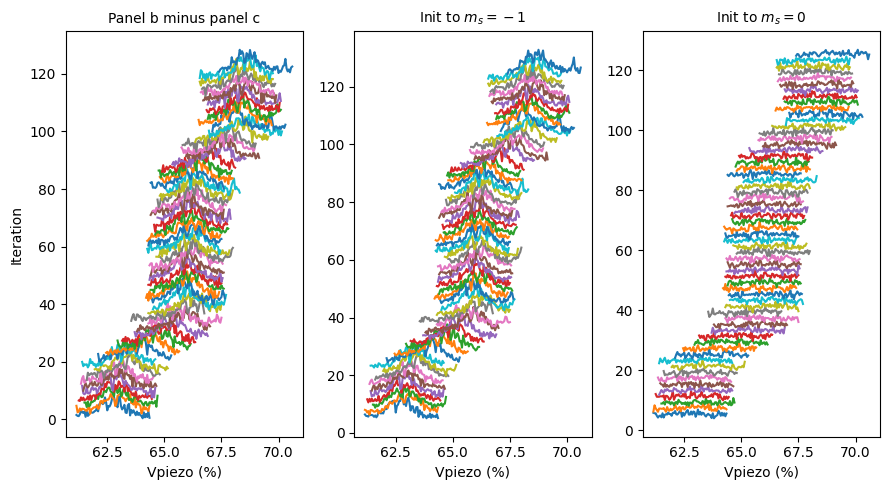

In [179]:
# ODMR
days = np.linspace(12,12,1)
fig, axs = plt.subplots(1,3,figsize=(9,5))
# Create a colormap with the custom midpoint
cmap = plt.get_cmap('bwr')  # You can choose any colormap
norm = mcolors.CenteredNorm(vcenter=-1)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanROFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (idx >= 959 and idx <= 1325 and np.mod(idx,2)==1):
            if (idx >= 1127 and idx <= 1189):
                dataArr = []
                datafile = mainFolder + dataFolder +'/ScanROFreqObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig-ref
                
                plot = axs[0].plot(x_s, contrast+idx)
                axs[0].set_xlabel('Vpiezo (%)')
                axs[0].set_ylabel('Iteration')
                axs[0].set_title('Panel b minus panel c',fontsize=10)

                plot1 = axs[1].plot(x_s, sig+idx)
                axs[1].set_xlabel('Vpiezo (%)')
                axs[1].set_title('Init to $m_s = -1$',fontsize=10)
                
                plot2 = axs[2].plot(x_s, ref+idx)
                axs[2].set_xlabel('Vpiezo (%)')
                axs[2].set_title('Init to $m_s = 0$',fontsize=10)
                
# for i in range(3):
#     axs[i].set_xlim((15,30))
#     axs[i].set_ylim((700,800))

plt.tight_layout()

[76.55 76.95 76.85 76.95 76.9  76.85 77.1  76.6  76.95 76.85 76.95 77.15
 77.05 77.1  76.85 76.8  76.8  76.8  77.2  77.   77.35 77.1  77.5  77.15
 77.45 77.2  77.3  77.25 77.05 77.25 77.4  77.3  77.3 ]
77.05606060606061
[-24.66666667 -27.         -25.66666667 -22.33333333 -28.33333333
 -26.33333333 -25.         -28.66666667 -23.         -26.66666667
 -22.33333333 -23.33333333 -24.66666667 -23.66666667 -25.33333333
 -27.33333333 -29.66666667 -26.33333333 -32.         -28.
 -24.33333333 -21.33333333 -21.66666667 -30.66666667 -26.66666667
 -29.66666667 -25.         -28.66666667 -27.33333333 -27.33333333
 -26.33333333 -28.33333333 -29.66666667]


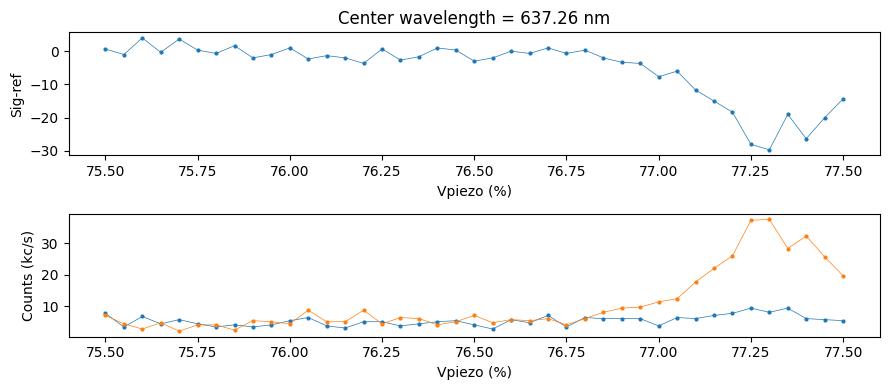

In [122]:
# y = np.average(dataArr, axis=0)
# ysig = np.average(sigArr, axis=0); yref = np.average(refArr, axis=0)
i=-1
y = dataArr[i]; ysig = sigArr[i]; yref = refArr[i]
x = np.array(x_s)
xmin = x[np.argmin(dataArr,axis=1)]
print(xmin)
print(np.average(xmin))
print(np.min(dataArr,axis=1))

fig, axs = plt.subplots(2,1, figsize=(9,4)) #
axs[0].plot(x,y, 'o-', markersize=2, linewidth = 0.5)
axs[0].set_xlabel('Vpiezo (%)')
axs[0].set_ylabel('Sig-ref')
axs[0].set_title("Center wavelength = 637.26 nm")

axs[1].plot(x, ysig, 'o-', markersize=2, linewidth = 0.5)
axs[1].plot(x, yref, 'o-', markersize=2, linewidth = 0.5)
axs[1].set_xlabel('Vpiezo (%)')
axs[1].set_ylabel('Counts (kc/s)')
# axs[0].set_xlim((70,101))
# # axs[0].set_ylim((-0.01,1))
# axs[1].set_xlim((70,101))

plt.tight_layout()

In [325]:
a

2

# Rabi

[ 3.55398751e-01  5.04476736e+01 -2.93742273e-01  6.14311729e-01
  2.77590779e+03]


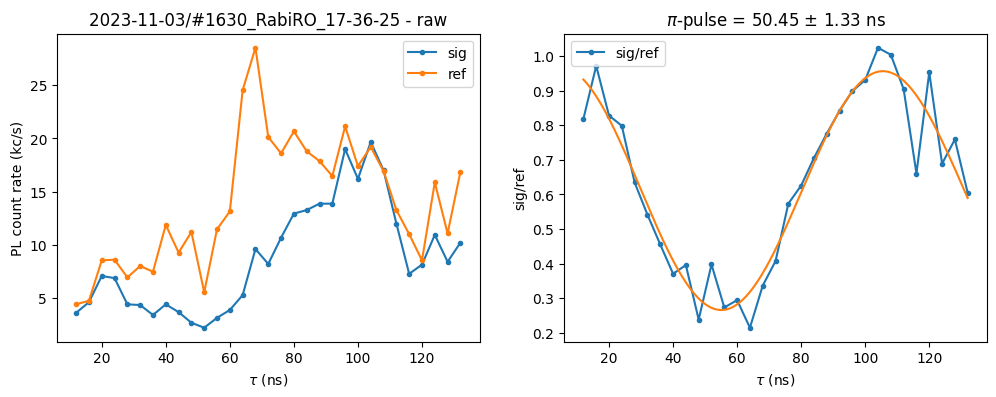

In [198]:
datafile = 'C:/Users/lukin2dmaterials/data/2023-11-03/#1620_RabiRO_17-11-16/RabiROObject_sig_set.dat'
datafile = 'C:/Users/lukin2dmaterials/data/2023-11-03/#1630_RabiRO_17-36-25/RabiROObject_sig_set.dat'
# datafile = 'C:/Users/lukin2dmaterials/data/2023-11-03/#1648_RabiRO_17-42-54/RabiROObject_sig_set.dat'
guess=(0.2, 60, 0, 0.9, 600)
sig, ref, popt, perr, x_s = dr.readData(datafile, type='RabiDecay', ifFit=1, guess=guess)

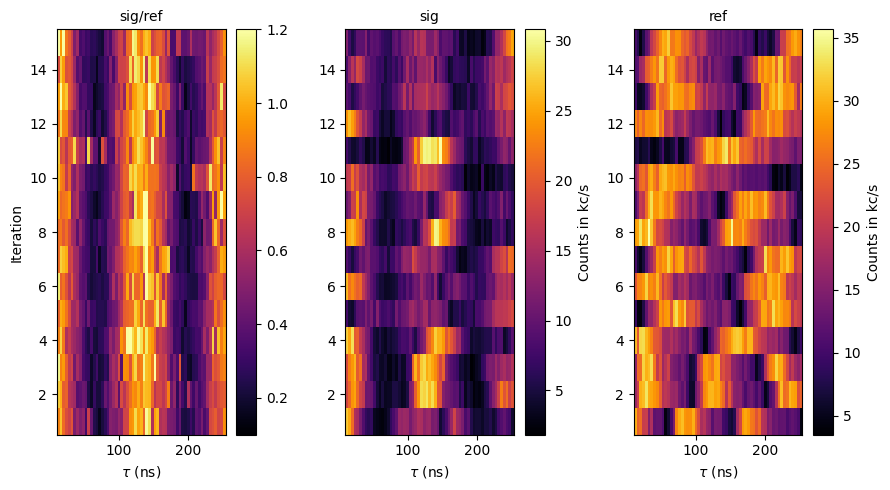

In [30]:
# Rabi
days = np.linspace(15,15,1)
dataArr = []; sigArr = []; refArr = []; idxs = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiRO' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (idx >= 883 and idx <= 914 and np.mod(idx,2)==1):
                datafile = mainFolder + dataFolder +'/RabiROObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                
                xPlot = x_s
                contrast = sig/ref
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)

sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]
sigArr = sigArr[sorted_indices]
refArr = refArr[sorted_indices]

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('$\\tau$ (ns)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('sig/ref',fontsize=10)
plot.set_clim(0.1,1.2)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('$\\tau$ (ns)')
axs[1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)
# plot1.set_clim(0,4)

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('$\\tau$ (ns)')
axs[2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

# for i in range(3):
#     # axs[i].set_xlim((82,84))
#     axs[i].set_ylim((600,610))

plt.tight_layout()


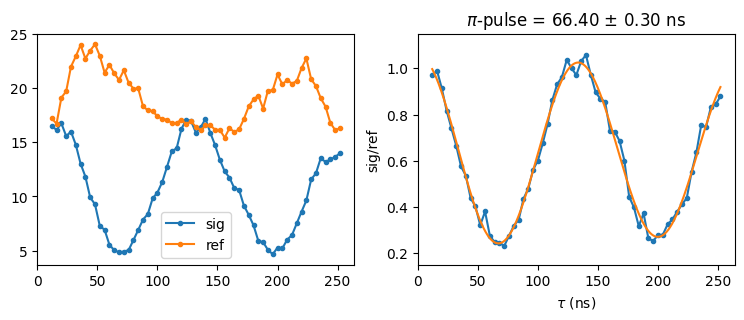

In [31]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(-1,-3,1):
    idx = int(idxs)
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot

    fig, axs = plt.subplots(1,2,figsize=(9,3))
    axs[1].plot(x,y, 'o-', markersize=3, label="sig/ref")
    axs[1].set_ylabel('sig/ref')
    axs[1].set_xlabel(r"$\tau$ (ns)")
    axs[1].set_ylim((0.15,1.15))

    axs[0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0].legend()
    # axs[0].set_title(datafile[31:-25],fontsize=10)

    guess = (0.66, 50, 0, 0.9, 600)


    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y, guess=guess)
    axs[1].plot(xfit, yfit, color='C1')
    axs[1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))

## Dual Rabi

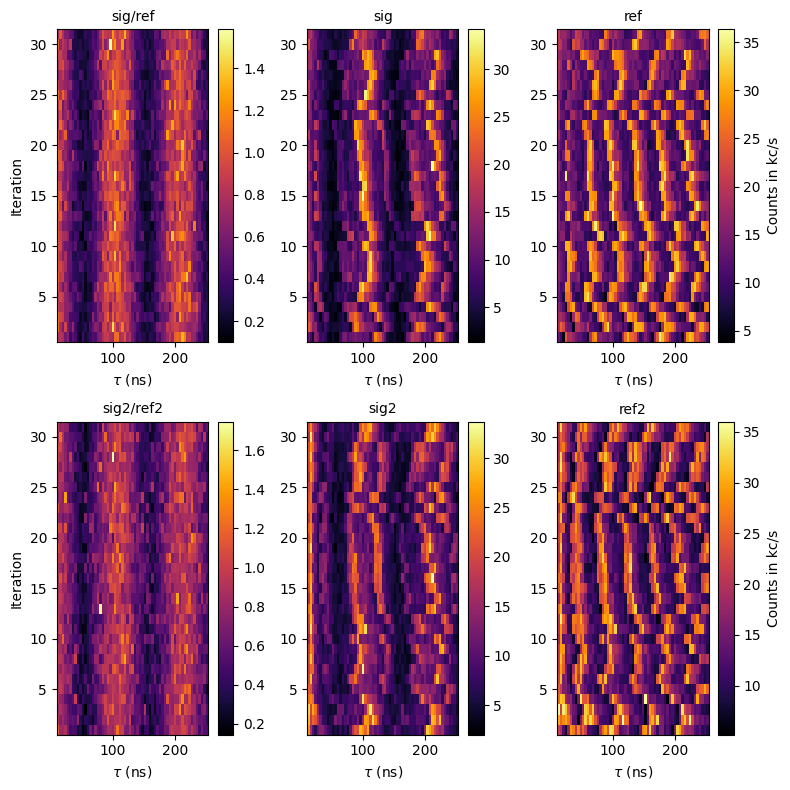

In [250]:
# Rabi
days = np.linspace(17,17,1)
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiRODualNV' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (idx >= 20 and idx <= 50):
                datafile = mainFolder + dataFolder +'/RabiRODualNVObject_sig2_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                
                xPlot = x_s
                contrast = sig/ref; contrast2 = sig2/ref2
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]; sigArr = sigArr[sorted_indices]; refArr = refArr[sorted_indices]
data2Arr = data2Arr[sorted_indices]; sig2Arr = sig2Arr[sorted_indices]; ref2Arr = ref2Arr[sorted_indices]

fig, axs = plt.subplots(2,3,figsize=(8,8))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)

plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
axs[0,0].set_xlabel('$\\tau$ (ns)')
axs[0,0].set_ylabel('Iteration')
axs[0,0].set_title('sig/ref',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[0,1].set_xlabel('$\\tau$ (ns)')
axs[0,1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
# plot1.set_clim(0,4)

plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[0,2].set_xlabel('$\\tau$ (ns)')
axs[0,2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
axs[1,0].set_xlabel('$\\tau$ (ns)')
axs[1,0].set_ylabel('Iteration')
axs[1,0].set_title('sig2/ref2',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
axs[1,1].set_xlabel('$\\tau$ (ns)')
axs[1,1].set_title('sig2',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
# plot1.set_clim(0,4)

plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
axs[1,2].set_xlabel('$\\tau$ (ns)')
axs[1,2].set_title('ref2',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plt.tight_layout()


[ 3.90279982e-01  5.16840677e+01 -7.72188582e-02  6.32631870e-01
  2.21354141e+03]
[ 3.33276870e-01  5.30194707e+01 -4.68803551e-02  6.98269936e-01
  1.28256369e+03]


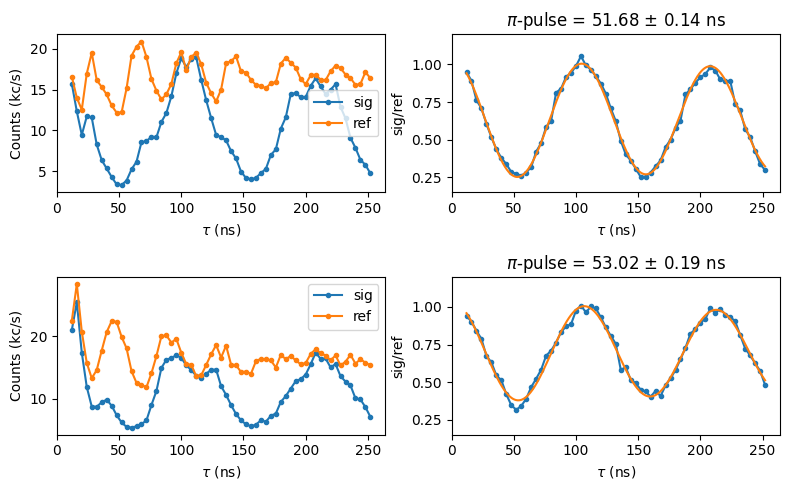

In [251]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(-1,-3,1):
    idx = int(idxs)
    x = xPlot
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    
    y2 = data2Arr[idx]; ys2 = sig2Arr[idx]; yr2 = ref2Arr[idx]
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', markersize=3, label="sig/ref")
    axs[0,1].set_ylabel('sig/ref')
    axs[0,1].set_xlabel(r"$\tau$ (ns)")
    axs[0,1].set_ylim((0.15,1.2))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_xlabel(r"$\tau$ (ns)")
    axs[0,0].set_ylabel('Counts (kc/s)')

    guess = (0.66, 50, 0, 0.9, 600)
    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y, guess=guess)
    axs[0,1].plot(xfit, yfit, color='C1')
    axs[0,1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))
    print(popt)

    ################################################################################
    axs[1,1].plot(x,y2, 'o-', markersize=3, label="sig/ref")
    axs[1,1].set_ylabel('sig/ref')
    axs[1,1].set_xlabel(r"$\tau$ (ns)")
    axs[1,1].set_ylim((0.15,1.2))

    axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig")
    axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ (ns)")
    axs[1,0].set_ylabel('Counts (kc/s)')

    guess = (0.66, 50, 0, 0.9, 600)
    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y2, guess=guess)
    axs[1,1].plot(xfit, yfit, color='C1')
    axs[1,1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))
    print(popt)

plt.tight_layout()

# T2E

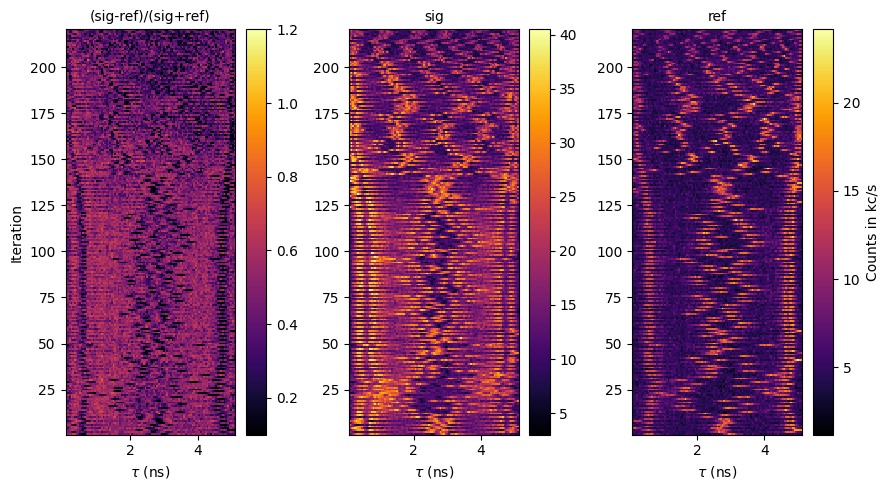

In [276]:
# November T2E
days = np.linspace(15,15,1)
dataArr = []; sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2ERO' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if idx >= 197 and idx <= 636 and np.mod(idx,2)==0:
                datafile = mainFolder + dataFolder +'/T2EROObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                n = None
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                contrast = (sig-ref)/(sig+ref)
                start_idx = 0
                x_s = x_s[start_idx:]
                contrast = contrast[start_idx:]
                xPlot = x_s; xPlot = np.array(xPlot); xPlot = np.flip(xPlot)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)
dataArr = np.array([row[::-1] if i % 2 != 0 else row for i, row in enumerate(dataArr)])
sigArr = np.array([row[::-1] if i % 2 != 0 else row for i, row in enumerate(sigArr)])
refArr = np.array([row[::-1] if i % 2 != 0 else row for i, row in enumerate(refArr)])

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot/1e3, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('$\\tau$ (ns)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('(sig-ref)/(sig+ref)',fontsize=10)
plot.set_clim(0.1,1.2)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('$\\tau$ (ns)')
axs[1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('$\\tau$ (ns)')
axs[2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

plt.tight_layout()

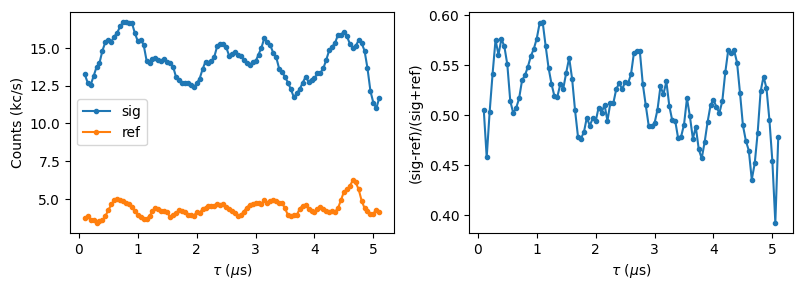

In [275]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(0,3,1):
    idx = int(idxs)
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot

    fig, axs = plt.subplots(1,2,figsize=(8,3))
    axs[1].plot(x/1e3,y, 'o-', markersize=3, label='(sig-ref)/(sig+ref)')
    axs[1].set_ylabel('(sig-ref)/(sig+ref)')
    axs[1].set_xlabel('$\\tau$ ($\mu$s)')
    # axs[1].set_ylim((0.15,1.05))

    axs[0].plot(x/1e3, ys, 'o-', markersize=3, label="sig")
    axs[0].plot(x/1e3, yr, 'o-', markersize=3, label="ref")
    axs[0].legend()
    axs[0].set_ylabel('Counts (kc/s)')
    axs[0].set_xlabel('$\\tau$ ($\mu$s)')

    plt.tight_layout()

## Randomized scan

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_9104\902224098.py:17: RuntimeWarning: invalid value encountered in divide
  contrast = (sig-ref)/(sig+ref)


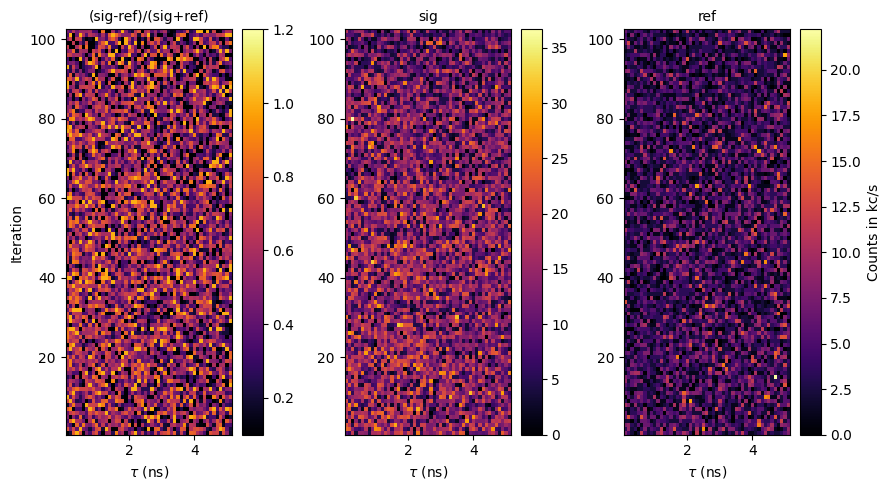

In [422]:
# November T2E
days = np.linspace(17,17,1)
dataArr = []; sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2ERO' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (((idx >= 993 and idx <= 1058) or (idx >= 1265 and idx <= 1488)) and np.mod(idx,2) == 1) or (((idx >= 1058 and idx <= 1264) or (idx >= 1488 and idx <= 1861)) and np.mod(idx,2) == 0):
            if (((idx >= 1058 and idx <= 1264)) and np.mod(idx,2) == 0):
                datafile = mainFolder + dataFolder +'/T2EROObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)

                sig = np.array(sig); ref = np.array(ref)
                contrast = (sig-ref)/(sig+ref)
                xPlot = x_s; xPlot = np.array(xPlot)

                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                contrast = contrast[sorted_indices]
                sig = sig[sorted_indices]
                ref = ref[sorted_indices]

                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)

# Replace 'nan' values with the value of the item preceding it
nan_indices = np.isnan(dataArr)
dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot/1e3, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('$\\tau$ (ns)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('(sig-ref)/(sig+ref)',fontsize=10)
plot.set_clim(0.1,1.2)

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('$\\tau$ (ns)')
axs[1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('$\\tau$ (ns)')
axs[2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

plt.tight_layout()

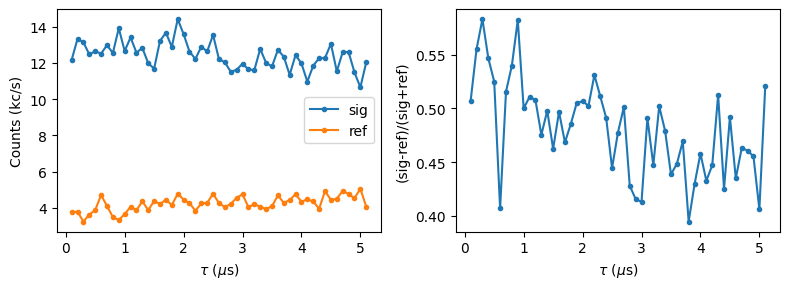

In [423]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(0,3,1):
    idx = int(idxs)
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot

    fig, axs = plt.subplots(1,2,figsize=(8,3))
    axs[1].plot(x/1e3,y, 'o-', markersize=3, label='(sig-ref)/(sig+ref)')
    axs[1].set_ylabel('(sig-ref)/(sig+ref)')
    axs[1].set_xlabel('$\\tau$ ($\mu$s)')
    # axs[1].set_xlim((-5,110))

    axs[0].plot(x/1e3, ys, 'o-', markersize=3, label="sig")
    axs[0].plot(x/1e3, yr, 'o-', markersize=3, label="ref")
    axs[0].legend()
    axs[0].set_ylabel('Counts (kc/s)')
    axs[0].set_xlabel('$\\tau$ ($\mu$s)')

    plt.tight_layout()

Peaks (kHz) [ 196.1  588.2  980.4 1568.6 4509.8]


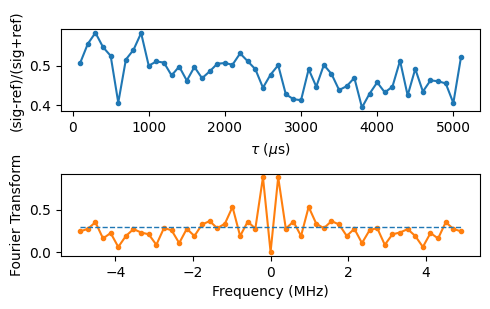

In [424]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 100e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(5,3))
axs[0].plot(x,y, 'o-', markersize=3,)
axs[0].set_xlabel(r"$\tau$ ($\mu$s)")
axs[0].set_ylabel('(sig-ref)/(sig+ref)')

axs[1].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Fourier Transform')
# axs[1].set_ylim((0,10))

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

threshold = 0.3
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (kHz)', np.round(fpeaks*1e3,1))

axs[1].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

## Dual T2E

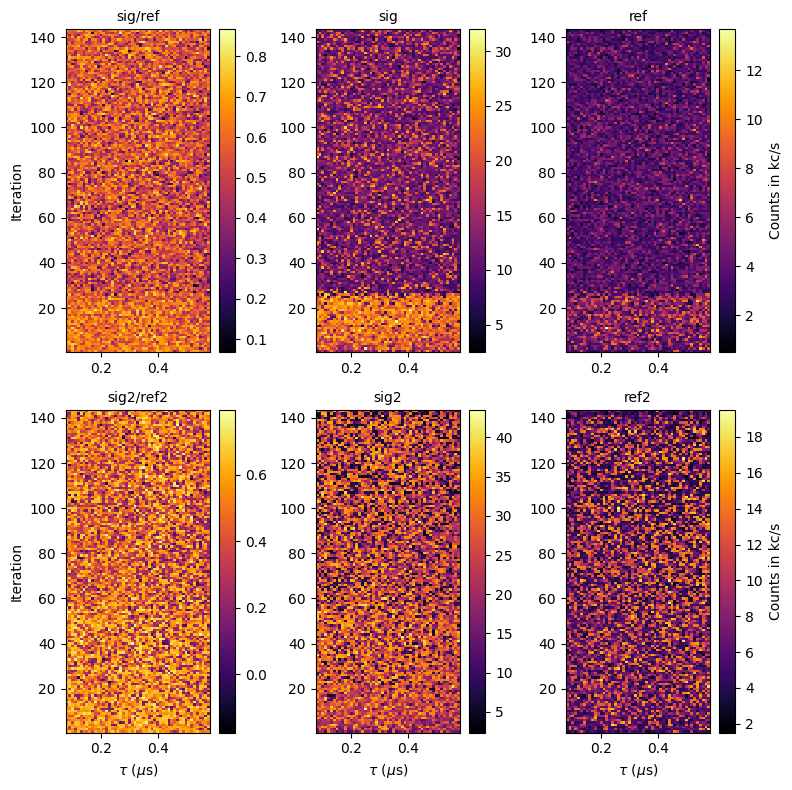

In [482]:
# T2E
days = np.linspace(19,20,2)
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'T2ERODualNV' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (day==19 and idx >= 1335) or (day==20 and idx <= 110):
                datafile = mainFolder + dataFolder +'/T2ERODualNVObject_sig2_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                
                # Sort data taken in random order
                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                
                contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

# sorted_indices = np.argsort(idxs)

# # Sort array1 in ascending order
# dataArr = dataArr[sorted_indices]; sigArr = sigArr[sorted_indices]; refArr = refArr[sorted_indices]
# data2Arr = data2Arr[sorted_indices]; sig2Arr = sig2Arr[sorted_indices]; ref2Arr = ref2Arr[sorted_indices]

# Replace 'nan' values with the value of the item preceding it
nan_indices = np.isnan(dataArr)
dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]
nan_indices = np.isnan(data2Arr)
data2Arr[nan_indices] = np.roll(data2Arr, 1, axis=1)[nan_indices]

fig, axs = plt.subplots(2,3,figsize=(8,8))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot/1e3, y)

plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
axs[0,0].set_ylabel('Iteration')
axs[0,0].set_title('sig/ref',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[0,1].set_title('sig',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
# plot1.set_clim(0,4)

plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[0,2].set_title('ref',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,0].set_ylabel('Iteration')
axs[1,0].set_title('sig2/ref2',fontsize=10)
# plot.set_clim(0.1,1.2)

plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
axs[1,1].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,1].set_title('sig2',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
# plot1.set_clim(0,4)

plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
axs[1,2].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,2].set_title('ref2',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
cb2.set_label("Counts in kc/s",fontsize=10)
# plot2.set_clim(0,4)

plt.tight_layout()


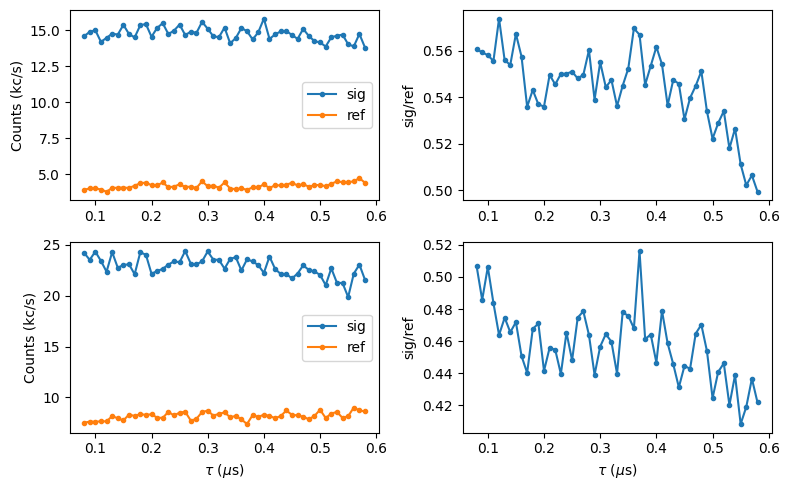

In [483]:
idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(-1,-3,1):
    idx = int(idxs)
    x = xPlot/1e3
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    
    y2 = data2Arr[idx]; ys2 = sig2Arr[idx]; yr2 = ref2Arr[idx]
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', markersize=3, label="sig/ref")
    axs[0,1].set_ylabel('sig/ref')
    # axs[0,1].set_xlim((-0.1,5.1))
    # axs[0,1].set_ylim((0.47,0.61))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_ylabel('Counts (kc/s)')

    ################################################################################
    axs[1,1].plot(x,y2, 'o-', markersize=3, label="sig/ref")
    axs[1,1].set_ylabel('sig/ref')
    axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    # axs[1,1].set_xlim((-0.1,5.1))

    axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig")
    axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1,0].set_ylabel('Counts (kc/s)')

plt.tight_layout()

Peaks (kHz) [ 3921.6  9803.9 15686.3 25490.2 33333.3]
Peaks (kHz) [ 3921.6 11764.7 17647.1 21568.6 29411.8]


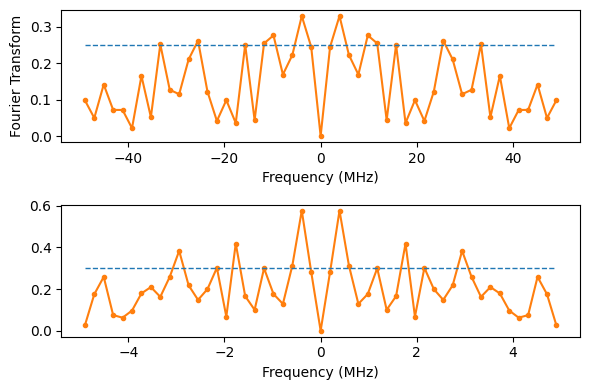

In [481]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 10e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

yfourier2 = np.fft.fft(y2-np.average(y2)); yfourier2 = np.abs(yfourier2)
f2 = np.fft.fftfreq(len(y2), 100e-9)/1e6

sorted_indices2 = np.argsort(f2)       # Get the indices that would sort f
f2 = f2[sorted_indices2]                # Sort f in ascending order
yfourier2 = yfourier2[sorted_indices2]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(6,4))
# axs[0].plot(x,y, 'o-', markersize=3,)
# axs[0].set_xlabel(r"$\tau$ ($\mu$s)")
# axs[0].set_ylabel('(sig-ref)/(sig+ref)')

axs[0].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C1')
axs[0].set_title('')
axs[0].set_xlabel('Frequency (MHz)')
axs[0].set_ylabel('Fourier Transform')
# axs[1].set_ylim((0,10))

axs[1].plot(f2, yfourier2, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
# axs[1].set_ylim((0,10))

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

threshold = 0.25
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print('Peaks (kHz)', np.round(fpeaks*1e3,1))

threshold2 = 0.3
peaks2 = find_peaks(yfourier2, threshold=threshold2)
fpeaks2 = f[peaks2]; fpeaks2 = fpeaks2[int(len(fpeaks2)/2):]
print('Peaks (kHz)', np.round(fpeaks2*1e3,1))

axs[0].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
axs[1].hlines(y=threshold2, xmin=min(f2), xmax=max(f2), linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

# Izn rate

Text(0, 0.5, 'Iteration')

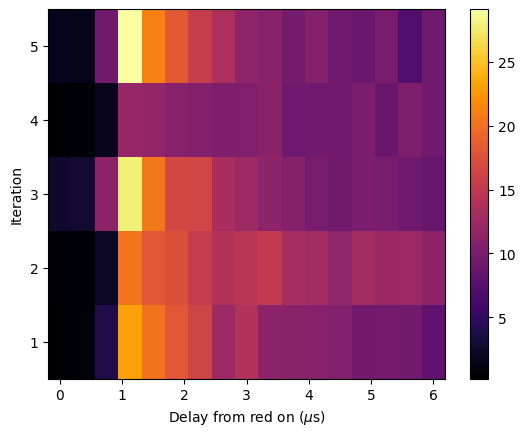

In [166]:
days = np.linspace(13,13, 1)
dataArr = []; gArr = []; err_gArr = []; cArr = []; err_cArr = []; r0Arr = []; err_r0Arr = []
# fig2, ax2 = plt.subplots()
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'CalibRedROIonizeRate' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if idx >= 61 and idx <= 65:
                read_duration = 250; power = 67; iters = 1e5; power532 = 55; delay1 = 1e3; t532 = 5e3 #durations[idx-7]
                datafile = mainFolder + dataFolder +'/CalibRedROIonizeRateObject_sig_set.dat'

                x, sig = dr.readDataNoRef(datafile)
                x = np.array(x)/1e3; sig = np.array(sig)
                n = 1
                if len(sig) < n: 
                        print("Bad data: " + datafile)
                else:
                    if math.isnan(sig[-1]): 
                        x = x[0:-1]; sig = sig[0:-1]
                    x = np.linspace(0, x[-1], len(x))
                    xPlot = x
                    y = sig
                    y = y/(read_duration/1e6)
                    y_avg = running_average(y)
                    dataArr.append(y)

                    xfit, yfit, popt, perr = dr.fitDecay(x, y, guess=(0.3,0.03,100))
                    g = 1e3/popt[2]; err_g = 1e3*(perr[2]/popt[2]**2)
                    gArr.append(g); err_gArr.append(err_g)
                    cArr.append(1e3*popt[1]); err_cArr.append(1e3*perr[1])
                    r0Arr.append(yfit[0]*1e3); err_r0Arr.append(1e3*(perr[1]+perr[0]))
                        
dataArr = np.array(dataArr); gArr = np.array(gArr); err_gArr = np.array(err_gArr); 
cArr = np.array(cArr); err_cArr = np.array(err_cArr); r0Arr = np.array(r0Arr); err_r0Arr = np.array(err_r0Arr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')
ax.set_xlabel("Delay from red on ($\mu$s)")
ax.set_ylabel(r"Iteration")

IndexError: index 5 is out of bounds for axis 0 with size 5

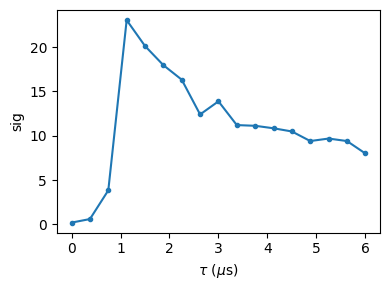

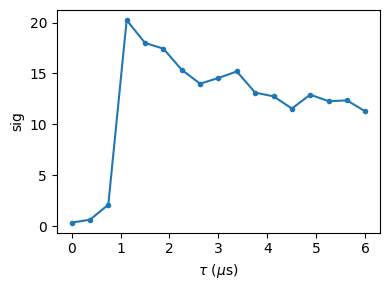

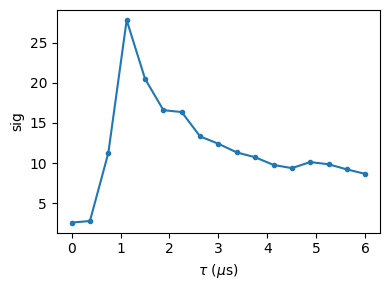

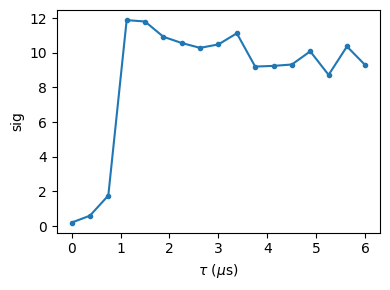

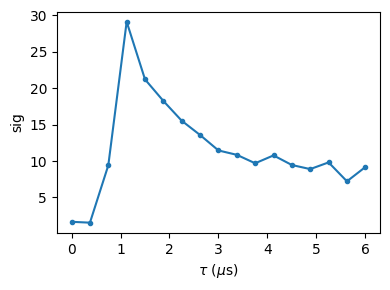

In [167]:
for idx in np.linspace(0,5,6):
    y = np.average(dataArr, axis=0)
    idx = int(idx)
    y = dataArr[idx]
    x = xPlot

    fig, ax = plt.subplots(1,1,figsize=(4,3))
    ax.plot(x,y, 'o-', markersize=3, label='(sig-ref)/(sig+ref)')
    ax.set_ylabel('sig')
    ax.set_xlabel('$\\tau$ ($\mu$s)')

    plt.tight_layout()

In [153]:
x

array([0.        , 0.42857143, 0.85714286, 1.28571429, 1.71428571,
       2.14285714, 2.57142857, 3.        , 3.42857143, 3.85714286,
       4.28571429, 4.71428571, 5.14285714, 5.57142857, 6.        ])

# Sat curve: for each current, sweep some vpz

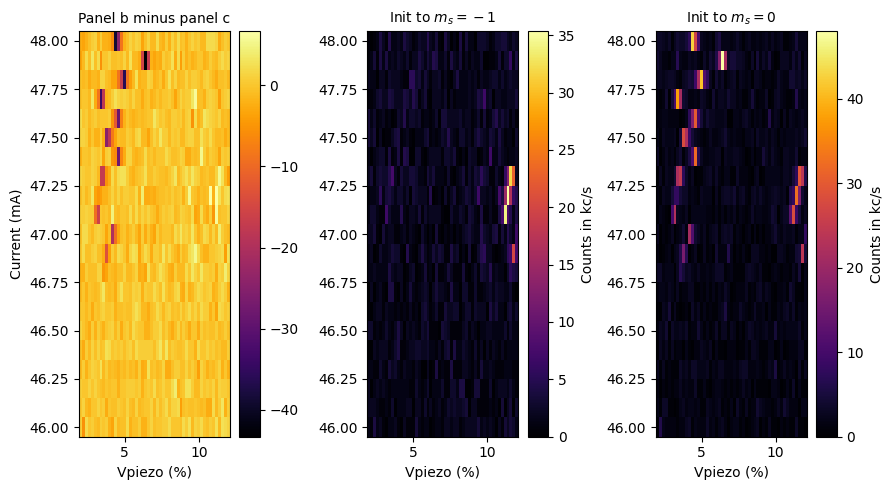

In [174]:
# ODMR
days = np.linspace(3,3,1)
dataArr = []; sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ScanROFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (day==1 and idx >= 51) or (day==2 and idx <= 112):
            if (day==3 and idx >= 1558 and idx <= 1578):
                datafile = mainFolder + dataFolder +'/ScanROFreqObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig-ref
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)

fig, axs = plt.subplots(1,3,figsize=(9,5))
N_datasets = np.size(dataArr,0)

Iarray = np.linspace(46,48,21)
# Iarray = np.linspace(46.5,50,36)
y = Iarray[0:N_datasets]

X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical', ax=axs[0])
axs[0].set_xlabel('Vpiezo (%)')
axs[0].set_ylabel('Current (mA)')
axs[0].set_title('Panel b minus panel c',fontsize=10)
# axs[0].set_ylim((100,200))

plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('Vpiezo (%)')
axs[1].set_title('Init to $m_s = -1$',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)

plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
axs[2].set_xlabel('Vpiezo (%)')
axs[2].set_title('Init to $m_s = 0$',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

plt.tight_layout()

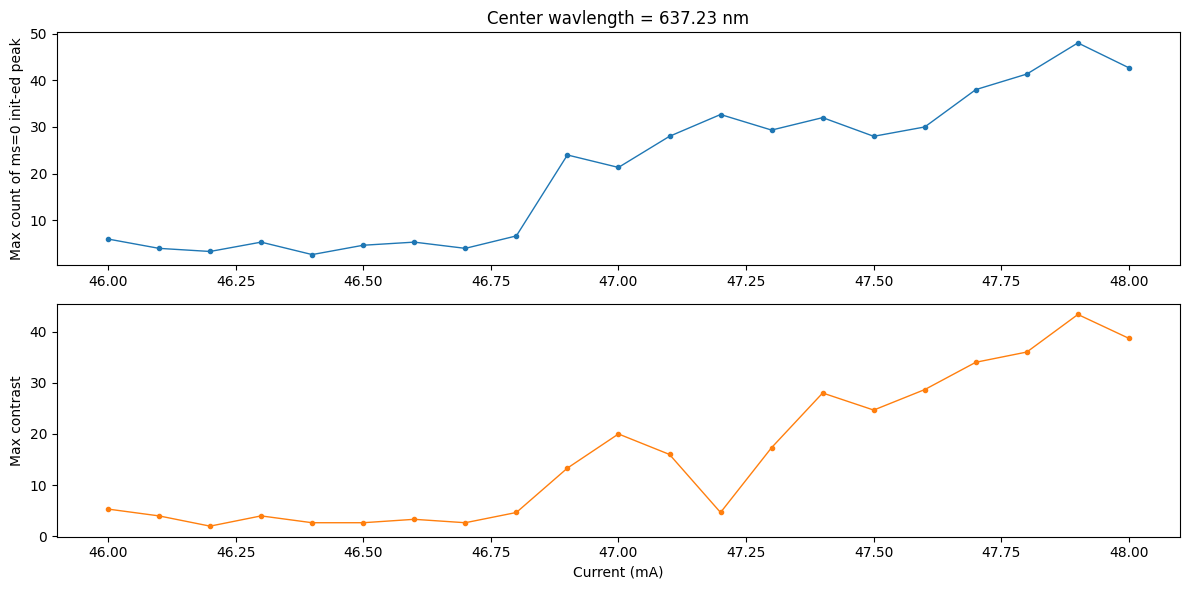

In [175]:
y = np.max(refArr,axis=1)
x = Iarray[0:len(y)]

fig, axs = plt.subplots(2,1,figsize=(12,6)) #
axs[0].plot(x,y, 'o-', markersize=3, linewidth = 1)
axs[0].set_ylabel('Max count of ms=0 init-ed peak')
axs[0].set_title("Center wavlength = 637.23 nm")

y1 = np.abs(np.min(dataArr,axis=1))
axs[1].plot(x,y1, 'o-', markersize=3, linewidth = 1, color='C1')
axs[1].set_xlabel('Current (mA)')
axs[1].set_ylabel('Max contrast')

plt.tight_layout()

In [ ]:
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-25/#005_CalibReadoutPhotonStat_11-48-36/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-25/#006_CalibReadoutPhotonStat_12-39-04/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-25/#008_CalibReadoutPhotonStat_15-45-47/CalibReadoutPhotonStatObject_sig_set.dat'

sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
    dataFilename, num_of_bins=50, binwidth=1, plot_hist_every=1, 
    ifDataSavedAsCountRate=False, ifLogColor=True)


In [ ]:
i = 1; num_of_iter_same_tau = len(xplot)
fig,ax = plt.subplots()
ax.hist(sig[i], bins=bins1DArray, edgecolor='black', density=True)
ax.set_xlabel(r"Count")
ax.set_ylabel(r"Probability")
ax.set_title(r"$\tau$ = " + str(np.round(yplot[i]/1e6,2)) + ". Signal. " + str(np.round(num_of_iter_same_tau/1e5,1)) + "e5 iters", 
                         fontsize=10)
# ax.set_xlim((600,900))
# ax.set_xlim((750,1250))
# ax.set_xlim((1000,1600))

# ax.set_xlim((0,100))
ax.set_ylim((0,0.00002))

In [ ]:
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-25/#011_CalibReadoutPhotonStat_16-48-28/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-26/#008_CalibReadoutPhotonStat_12-28-55/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-26/#009_CalibReadoutPhotonStat_12-45-16/CalibReadoutPhotonStatObject_sig_set.dat'

sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
    dataFilename, num_of_bins=50, binwidth=1, plot_hist_every=1, 
    ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=True)


(0.0, 2e-05)

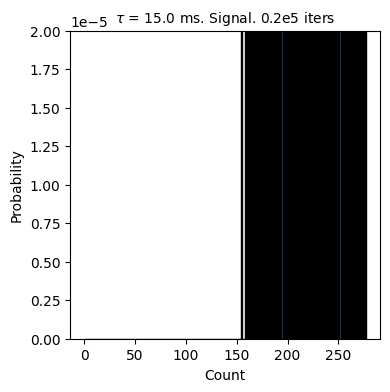

In [16]:
i = 0; num_of_iter_same_tau = len(xplot)
fig,ax = plt.subplots(figsize=(4,4))
# fig,ax = plt.subplots()
ax.hist(sig[i], bins=bins1DArray, edgecolor='black', density=True)
ax.set_xlabel(r"Count")
ax.set_ylabel(r"Probability")
ax.set_title(r"$\tau$ = " + str(np.round(yplot[i]/1e6,2)) + " ms. Signal. " + str(np.round(num_of_iter_same_tau/1e5,1)) + "e5 iters", 
                         fontsize=10)
# ax.set_xlim((600,900))
# ax.set_xlim((750,1250))
# ax.set_xlim((1000,1600))

# ax.set_xlim((120,300))
ax.set_ylim((0,0.00002))

In [ ]:
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-26/#010_CalibReadoutPhotonStat_13-27-52/CalibReadoutPhotonStatObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-26/#011_CalibReadoutPhotonStat_13-51-01/CalibReadoutPhotonStatObject_sig_set.dat'

sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
    dataFilename, num_of_bins=50, binwidth=10, plot_hist_every=5000, 
    ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=False,
    ifRealTimeMonitor=True, num_of_iter=1000)


Text(0, 0.5, 'Total counts (c/1000 iters)')

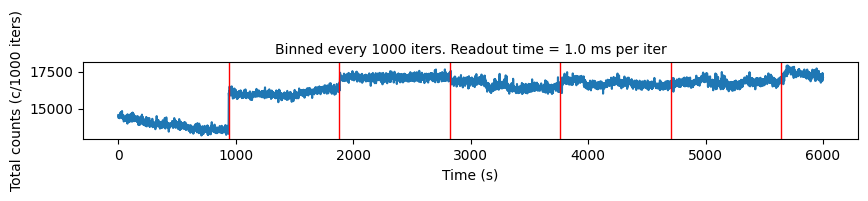

In [44]:
num_of_pb_iter = 1000
readout_time_per_iter_ns = 1e6
time_per_iter_second = num_of_pb_iter*readout_time_per_iter_ns/1e9

xplot = np.arange(len(yplot))*time_per_iter_second
yplot = np.sum(sig,axis=1)
fig, ax = plt.subplots(figsize=(10,1))
ax.plot(xplot, yplot)
for i in range (1,7):
    ax.axvline(x=941*i, ymin=0, ymax = 1, color='red', linewidth=1)
ax.set_xlabel(r"Time (s)")
ax.set_title(r"Binned every " + str(num_of_pb_iter) + " iters. Readout time = " 
              + str(readout_time_per_iter_ns/1e6) + " ms per iter", fontsize=10)
ax.set_ylabel("Total counts (c/1000 iters)")
# ax.set_xlim((0,1000))


[9.12007529e-02 1.46076658e-02 1.93926082e+02]
[4.59271401e-03 2.71396872e-03 2.16347546e+01]


5.156603942480745

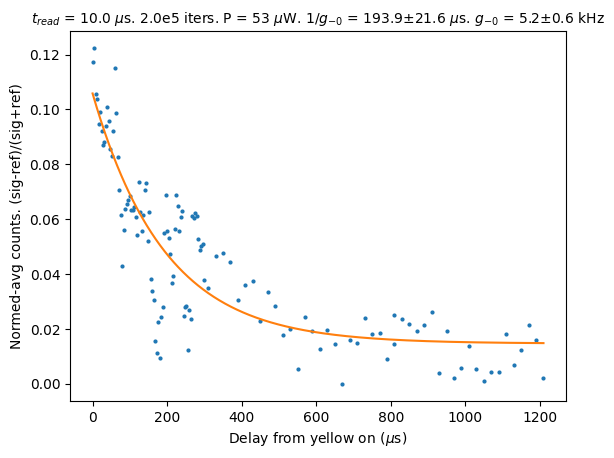

In [28]:
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-28/#001_CalibYellowIonizeRate_02-11-33/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-31/#014_CalibYellowIonizeRate_15-20-14/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-05-31/#016_CalibYellowIonizeRate_21-18-14/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-01/#002_CalibYellowIonizeRate_10-55-15/CalibYellowIonizeRateObject_sig_set.dat'

x, sig, ref = dr.readDataNoPlot(dataFilename)
x = np.array(x)/1e3; sig = np.array(sig); ref = np.array(ref)
if math.isnan(sig[-1]): 
    x = x[0:-1]; sig = sig[0:-1]; ref = ref[0:-1]
# y = sig
y = (sig-ref)/(sig+ref)

#################################
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-01/#004_CalibYellowIonizeRate_15-53-50/CalibYellowIonizeRateObject_sig_set.dat'

x2, sig2, ref2 = dr.readDataNoPlot(dataFilename)
x2 = np.array(x2)/1e3; sig2 = np.array(sig2); ref2 = np.array(ref2)
if math.isnan(sig2[-1]): 
    x2 = x2[0:-1]; sig2 = sig2[0:-1]; ref2 = ref2[0:-1]
# y2 = sig2
y2 = (sig2-ref2)/(sig2+ref2)

x = np.concatenate((x,x2)); y = np.concatenate((y,y2))

#################################
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-02/#002_CalibYellowIonizeRate_12-23-37/CalibYellowIonizeRateObject_sig_set.dat'

x3, sig3, ref3 = dr.readDataNoPlot(dataFilename)
x3 = np.array(x3)/1e3; sig3 = np.array(sig3); ref3 = np.array(ref3)
if math.isnan(sig3[-1]): 
    x3 = x3[0:-1]; sig3 = sig3[0:-1]; ref3 = ref3[0:-1]
# y3 = sig3
y3 = (sig3-ref3)/(sig3+ref3)

x = np.concatenate((x,x3)); y = np.concatenate((y,y3))

###########################################

read_duration = 10e3; power = 53; iters = 2e5

fig,ax = plt.subplots()
ax.plot(x,y, 'o', markersize=2)
ax.set_xlabel("Delay from yellow on ($\mu$s)")
ax.set_ylabel("Normed-avg counts. (sig-ref)/(sig+ref)")
xfit, yfit, popt, perr = dr.fitDecay(x, y, guess=(0.15,0.03,1))
ax.plot(xfit, yfit,)
ax.set_title("$t_{read}$ = %.1f $\mu$s. %.1fe5 iters. P = %.0f $\mu$W. 1/$g_{-0}$ = %.1f$\pm$%.1f $\mu$s. $g_{-0}$ = %.1f$\pm$%.1f kHz" %
             (read_duration/1e3, iters/1e5, power, popt[2], perr[2], 1000/popt[2], 1000*(perr[2]/popt[2]**2)), fontsize=10)
print(popt)
print(perr)
1/popt[2]*1000


[5.05558691e-01 2.22945135e-02 3.81456672e+03]
[3.81309889e-02 1.41377635e-02 5.90463096e+02]
55.98885793871866


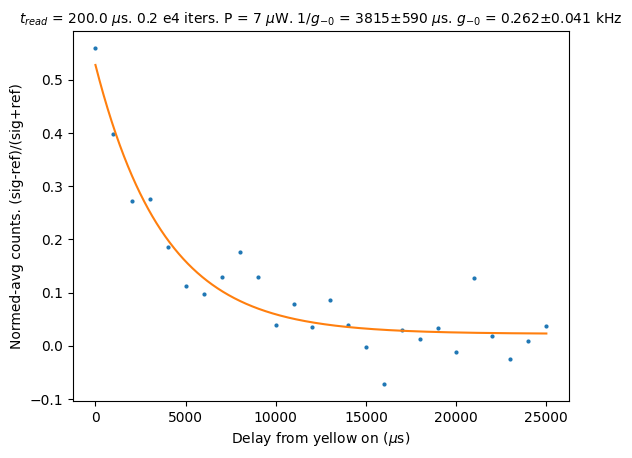

In [45]:
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-02/#004_CalibYellowIonizeRate_22-11-19/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-03/#001_CalibYellowIonizeRate_21-52-22/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-04/#003_CalibYellowIonizeRate_21-03-15/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-04/#004_CalibYellowIonizeRate_21-17-59/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-04/#005_CalibYellowIonizeRate_21-43-12/CalibYellowIonizeRateObject_sig_set.dat'
# dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-04/#006_CalibYellowIonizeRate_22-14-25/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-04/#010_CalibYellowIonizeRate_22-41-18/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-04/#011_CalibYellowIonizeRate_23-10-47/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-04/#012_CalibYellowIonizeRate_23-32-17/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-04/#013_CalibYellowIonizeRate_23-44-05/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-05/#001_CalibYellowIonizeRate_00-01-15/CalibYellowIonizeRateObject_sig_set.dat'
# dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-05/#002_CalibYellowIonizeRate_01-30-02/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-05/#034_CalibYellowIonizeRate_12-17-45/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-08/#028_CalibYellowIonizeRate_02-12-45/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-14/#018_CalibYellowIonizeRate_21-43-52/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-21/#005_CalibYellowIonizeRate_19-10-59/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-21/#006_CalibYellowIonizeRate_19-40-27/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-22/#007_CalibYellowIonizeRate_16-25-56/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-06-26/#001_CalibYellowIonizeRate_12-07-03/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-20/#013_CalibYellowIonizeRate_20-59-12/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-21/#002_CalibYellowIonizeRate_06-16-03/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-21/#005_CalibYellowIonizeRate_12-51-55/CalibYellowIonizeRateObject_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-27/#324_CalibYellowIonizeRate_13-57-31/CalibYellowIonizeRateObject_sig_set.dat'

x, sig, ref = dr.readDataNoPlot(dataFilename)
x = np.array(x)/1e3; sig = np.array(sig); ref = np.array(ref)
if math.isnan(sig[-1]): 
    x = x[0:-1]; sig = sig[0:-1]; ref = ref[0:-1]
y = (sig-ref)/(sig+ref)
# y = sig

# x = x[0:27]
# y = y[0:27]

read_duration = 200e3; power = 7.4; iters = 2e3

fig,ax = plt.subplots()
# ax.plot(x,sig)
# ax.plot(x,ref)
ax.plot(x,y, 'o', markersize=2)
# ax.axhline(y = 0.0169, xmin=0, xmax = 1, color='red', linewidth=1)
ax.set_xlabel("Delay from yellow on ($\mu$s)")
ax.set_ylabel("Normed-avg counts. (sig-ref)/(sig+ref)")
xfit, yfit, popt, perr = dr.fitDecay(x, y, guess=(0.03,-0.03,6e4))
ax.plot(xfit, yfit,)
ax.set_title("$t_{read}$ = %.1f $\mu$s. %.1f e4 iters. P = %.0f $\mu$W. 1/$g_{-0}$ = %.0f$\pm$%.0f $\mu$s. $g_{-0}$ = %.3f$\pm$%.3f kHz" %
             (read_duration/1e3, iters/1e4, power, popt[2], perr[2], 1000/popt[2], 1000*(perr[2]/popt[2]**2)), fontsize=10)
print(popt)
print(perr)
1/popt[2]*1000
print(max(y*100))

[0.34168336673346694, 0.3429859719438878, 0.34168336673346694, 0.34133266533066137, 0.34380761523046094, 0.34592518370073483, 0.3471514457486401, 0.3479959919839679, 0.3483633934535738, 0.3489579158316633, 0.34986336308981597, 0.34951569806279226, 0.3501926930784646, 0.3491125107357572, 0.3483500334001336, 0.34792084168336673, 0.3476128728044324, 0.34714985526608777, 0.34665119713110437, 0.3464529058116233, 0.3463498425422274, 0.34659318637274555, 0.3465539775202579, 0.3462007348029392, 0.3460681362725451, 0.3460536457530446, 0.34641134120092043, 0.3459633552819926, 0.3459056043120725, 0.34555778223112904, 0.34581420906328797, 0.34554734468937887, 0.34508410760915786, 0.34424731816574333, 0.3440939020898942, 0.34344800712536194, 0.34275578183393823, 0.3420419786942307, 0.342222907353168, 0.341928857715431, 0.3414683024585758, 0.34153545185609324, 0.34094701029966923, 0.3402623428675534, 0.33974615898463606, 0.33936568789753435, 0.338992879375773, 0.33863142952571823, 0.3379166496257823

Text(0, 0.5, 'Difference in counts (c)')

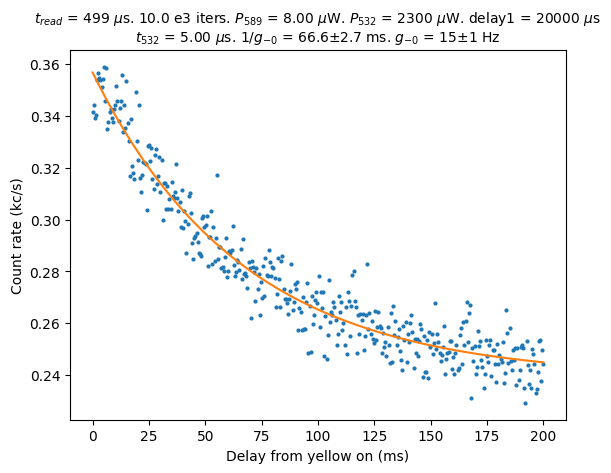

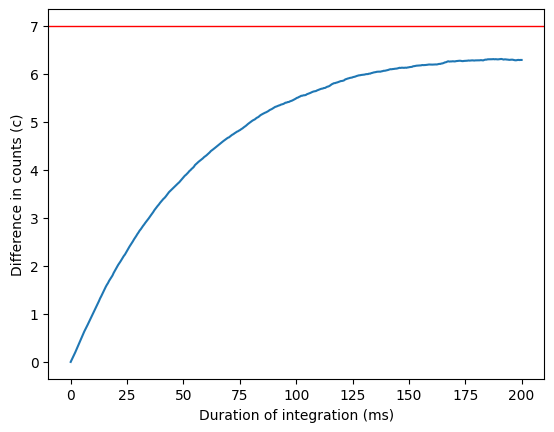

In [275]:
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-27/#362_CalibYellowIonizeRate2_16-36-37/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-27/#367_CalibYellowIonizeRate2_19-16-49/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-27/#368_CalibYellowIonizeRate2_19-27-45/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-29/#104_CalibYellowIonizeRate2_15-46-39/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-29/#140_CalibYellowIonizeRate2_21-38-54/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-31/#002_CalibYellowIonizeRate2_11-57-08/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-31/#006_CalibYellowIonizeRate2_13-00-46/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-31/#061_CalibYellowIonizeRate2_21-46-45/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-07-31/#062_CalibYellowIonizeRate2_22-19-06/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-01/#054_CalibYellowIonizeRate2_11-08-19/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-01/#055_CalibYellowIonizeRate2_11-25-00/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-01/#093_CalibYellowIonizeRate2_17-07-15/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-02/#016_CalibYellowIonizeRate2_02-32-30/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-02/#017_CalibYellowIonizeRate2_03-09-50/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-02/#094_CalibYellowIonizeRate2_17-28-58/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-02/#095_CalibYellowIonizeRate2_17-59-27/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-02/#096_CalibYellowIonizeRate2_18-29-39/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-02/#097_CalibYellowIonizeRate2_19-03-44/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-02/#016_CalibYellowIonizeRate2_02-32-30/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-03/#029_CalibYellowIonizeRate2_14-37-25/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-04/#023_CalibYellowIonizeRate2_17-06-04/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-04/#048_CalibYellowIonizeRate2_22-06-55/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-04/#051_CalibYellowIonizeRate2_22-54-30/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-05/#009_CalibYellowIonizeRate2_01-15-39/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-07/#008_CalibYellowIonizeRate2_03-38-38/CalibYellowIonizeRate2Object_sig_set.dat'
dataFilename = 'C:/Users/lukin2dmaterials/data/2023-08-07/#008_CalibYellowIonizeRate2_03-38-38/CalibYellowIonizeRate2Object_sig_set.dat'

x, sig = dr.readDataNoRef(dataFilename)
x = np.array(x)/1e6; sig = np.array(sig)
if math.isnan(sig[-1]): 
    x = x[0:-1]; sig = sig[0:-1]

x = np.linspace(0, x[-1], len(x))
y = sig

read_duration = 499e3; power = 8; iters = 10e3; power532 = 2300; delay1 = 20e6; t532 = 5e3
y = y/(read_duration/1e6)
# x = x[7:]; y = y[7:]

y_avg = running_average(y)

fig,ax = plt.subplots()
ax.plot(x,y, 'o', markersize=2)
# ax.axhline(y = 0.0169, xmin=0, xmax = 1, color='red', linewidth=1)
ax.set_xlabel("Delay from yellow on (ms)")
ax.set_ylabel("Count rate (kc/s)")
xfit, yfit, popt, perr = dr.fitDecay(x, y, guess=(0.03,-0.03,6e4)) 
ax.plot(xfit, yfit,)
s1 = "$t_{read}$ = %.0f $\mu$s. %.1f e3 iters. $P_{589}$ = %.2f $\mu$W. $P_{532}$ = %.0f $\mu$W. delay1 = %.0f $\mu$s" % (read_duration/1e3, iters/1e3, power, power532, delay1/1e3)
s2 = "$t_{532}$ = %.2f $\mu$s. 1/$g_{-0}$ = %.1f$\pm$%.1f ms. $g_{-0}$ = %.0f$\pm$%.0f Hz" %(t532/1e3, popt[2], perr[2], 1e3/popt[2], 1e3*(perr[2]/popt[2]**2))
ax.set_title(s1 + "\n" + s2, fontsize=10)
# ax.plot(x,y_avg, 'o', markersize=2)
print(popt)
print(perr)
1/popt[2]*1000
print(max(y*100))

fig, ax = plt.subplots()
ax.plot(x, (x*y_avg)-(x*yfit[-1]))
ax.axhline(y = 7, xmin=0, xmax = 1, color='red', linewidth=1)
# ax.plot(x, (x*yfit[-1]))
# ax.plot(x, ((x*y_avg)-(x*yfit[-1])) / (x*yfit[-1]))
ax.set_xlabel("Duration of integration (ms)")
ax.set_ylabel("Difference in counts (c)")
# ax.set_xlim((0,10))
# ax.set_ylim((0,5))

In [58]:
len(y)

31

In [ ]:
filename = 'C:/Users/lukin2dmaterials/data/2023-06-08/#043_CalibReadoutPhotonStat_18-15-15/snapshot.json'
f = open(filename)
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
# Iterating through the json list
for k, v in data.items():
    if k != 'loop' and k!= 'arrays':
        print (k, v)


In [ ]:
# Repeat measuring ionization rates at the same power
days = np.linspace(21,21,1)
dataArr = []; gArr = []; err_gArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-07-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'CalibYellowIonizeRate' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 16 and idx <= 20:
                read_duration = 400e3; power = 18; iters = 2e3

                datafile = mainFolder + dataFolder +'/CalibYellowIonizeRateObject_sig_set.dat'

                x, sig, ref = dr.readDataNoPlot(datafile)
                x = np.array(x)/1e3; sig = np.array(sig); ref = np.array(ref)
                n = 31
                if len(sig) < n: 
                        print("Bad data: " + datafile)
                else:
                    if math.isnan(sig[-1]): 
                        x = x[0:-1]; sig = sig[0:-1]; ref = ref[0:-1]
                    xPlot = x
                    y = (sig-ref)/(sig+ref)
                    # y = sig-ref
                    y = sig
                    # x = x[0:21]
                    # y = y[0:21]
                    dataArr.append(y)

                    xfit, yfit, popt, perr = dr.fitDecay(x, y, guess=(0.3,0.03,100))
                    g = 1000/popt[2]; err_g = 1000*(perr[2]/popt[2]**2)
                    gArr.append(g); err_gArr.append(err_g)

                    if np.mod(idx,100) == 0:
                        fig,ax = plt.subplots()
                        ax.plot(x,y, 'o', markersize=2)
                        ax.set_xlabel("Delay from yellow on ($\mu$s)")
                        ax.set_ylabel("Normed-avg counts. (sig-ref)/(sig+ref)")
                        ax.plot(xfit, yfit,)
                        ax.set_title("$t_{read}$ = %.1f $\mu$s. %.1fe5 iters. P = %.0f $\mu$W. 1/$g_{-0}$ = %.0f$\pm$%.0f $\mu$s. $g_{-0}$ = %.2f$\pm$%.2f kHz" %
                                    (read_duration/1e3, iters/1e5, power, popt[2], perr[2], 1000/popt[2], 1000*(perr[2]/popt[2]**2)), fontsize=10)

dataArr = np.array(dataArr); gArr = np.array(gArr); err_gArr = np.array(err_gArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')
ax.set_xlabel("Delay from yellow on ($\mu$s)")
ax.set_ylabel(r"Iteration")


fig, ax = plt.subplots(figsize=(5,4))
plot1 = ax.errorbar(y, gArr, err_gArr, color='C0', label="Ionization rate", linestyle='', marker='.')

ax.set_xlabel(r"Iteration")
ax.set_ylabel(r"$g_{-0}$ (kHz)")
# ax.set_title(r"$I_{sat}$ = %.1f kc/s, $P_{sat}/A$ = %.2f $\times 10^9$ W/m$^{2}$" % (popt[0], popt[1]))

g_mean = np.sum(gArr/err_gArr**2)/np.sum(1/err_gArr**2)
err_gMean = np.sqrt(1/np.sum(1/err_gArr**2))
print("max = " + str(np.max(gArr + err_gArr)))
print("min = " + str(np.min(gArr - err_gArr)))
print("g_mean = " + str(g_mean))
print("err_gMean = " + str(err_gMean))
print(np.average(gArr))

firstY = np.max(dataArr, axis=1)*(1e6/read_duration)
print("max first count rate = "  + str(np.max(firstY)))
print("min first count rate = " + str(np.min(firstY)))
print("avg first count rate = " + str(np.average(firstY)))

max = 8.192754002793189
min = 1.931309137001751
g_mean = 5.858488966317869
err_gMean = 0.07248098647147792
5.7227489741099085
max first count rate = 0.83533801069072
min first count rate = 0.4578294866285677
avg first count rate = 0.6920989607806125


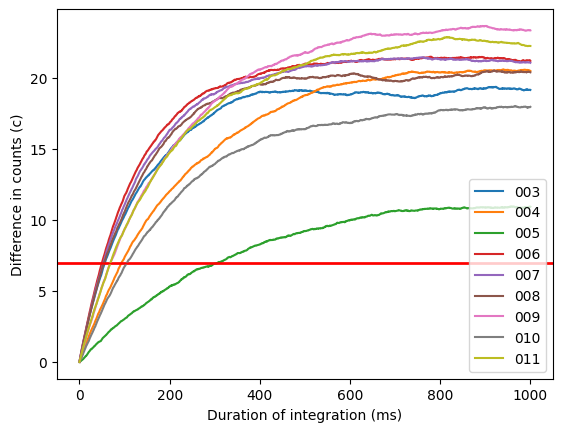

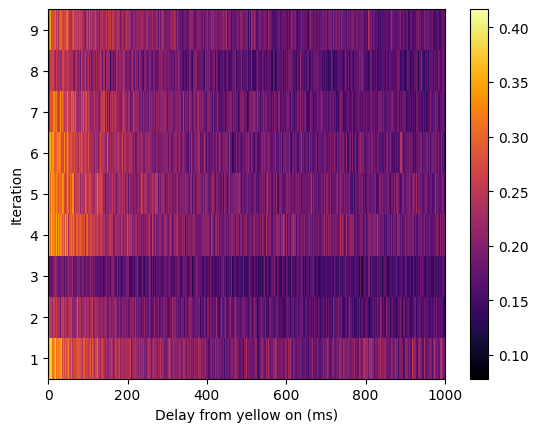

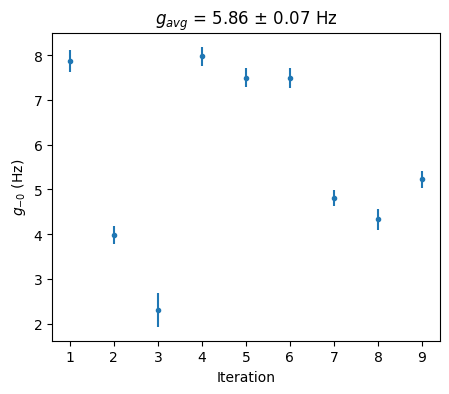

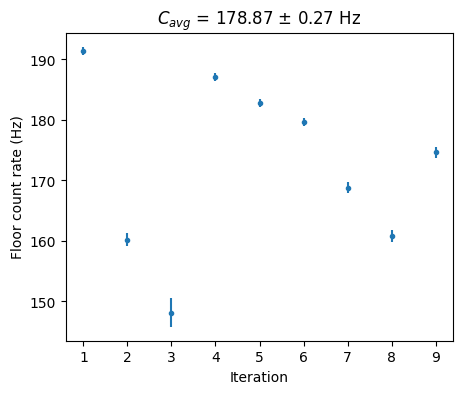

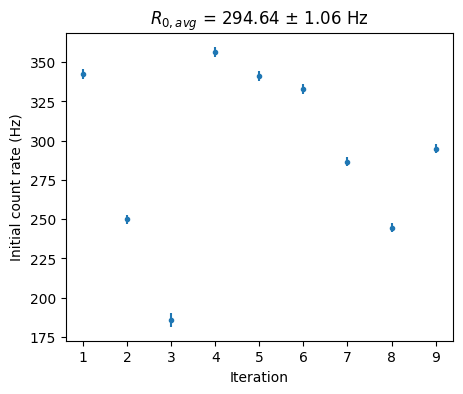

In [37]:
# Repeat measuring ionization rates at the same power
# days = np.linspace(5,6,2)
days = np.linspace(1,1, 1)
dataArr = []; gArr = []; err_gArr = []; cArr = []; err_cArr = []; r0Arr = []; err_r0Arr = []
fig2, ax2 = plt.subplots()
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-09-' + str(int(day)).zfill(2) + '/'
    # durations = np.array((50, 100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000))
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'CalibYellowIonizeRate2' in dataFolder:
            idx = int(dataFolder[1:4])
            # if (day == 6 and idx >= 1 and idx <= 56) or (day == 5 and idx >= 79):
            if idx >= 3 and idx <=11:
                read_duration = 499e3; power = 1.9; iters = 1e3; power532 = 55; delay1 = 5e6; t532 = 50e3 #durations[idx-7]
                datafile = mainFolder + dataFolder +'/CalibYellowIonizeRate2Object_sig_set.dat'

                x, sig = dr.readDataNoRef(datafile)
                x = np.array(x)/1e6; sig = np.array(sig)
                n = 1
                if len(sig) < n: 
                        print("Bad data: " + datafile)
                else:
                    if math.isnan(sig[-1]): 
                        x = x[0:-1]; sig = sig[0:-1]
                    x = np.linspace(0, x[-1], len(x))
                    xPlot = x
                    y = sig
                    y = y/(read_duration/1e6)
                    y_avg = running_average(y)
                    dataArr.append(y)

                    xfit, yfit, popt, perr = dr.fitDecay(x, y, guess=(0.3,0.03,100))
                    g = 1e3/popt[2]; err_g = 1e3*(perr[2]/popt[2]**2)
                    gArr.append(g); err_gArr.append(err_g)
                    cArr.append(1e3*popt[1]); err_cArr.append(1e3*perr[1])
                    r0Arr.append(yfit[0]*1e3); err_r0Arr.append(1e3*(perr[1]+perr[0]))

                    if np.mod(idx,1) == 0:
                        # fig,ax = plt.subplots()
                        # ax.plot(x,y, 'o', markersize=2)
                        # ax.set_xlabel("Delay from yellow on (ms)")
                        # ax.set_ylabel("Count rate (kc/s)")
                        # ax.plot(xfit, yfit,)
                        # s1 = "$t_{read}$ = %.0f $\mu$s. %.1f e3 iters. $P_{589}$ = %.2f $\mu$W. $P_{532}$ = %.0f $\mu$W. delay1 = %.1f ms" % (read_duration/1e3, iters/1e3, power, power532, delay1/1e6)
                        # s2 = "$t_{532}$ = %.2f $\mu$s. 1/$g_{-0}$ = %.1f$\pm$%.1f ms. $g_{-0}$ = %.1f$\pm$%.1f Hz. C = %.0f$\pm$%.0f c/s" %(t532/1e3, popt[2], perr[2], 1e3/popt[2], 1e3*(perr[2]/popt[2]**2), popt[1]*1e3, 1e3*perr[1])
                        # ax.set_title(s1 + "\n" + s2, fontsize=10)

                        ax2.plot(x, (x*y_avg)-(x*yfit[-1]), label=dataFolder[1:4])
                        ax2.axhline(y = 7, xmin=0, xmax = 1, color='red', linewidth=1)
                        ax2.set_xlabel("Duration of integration (ms)")
                        ax2.set_ylabel("Difference in counts (c)")
                        ax2.legend()
                        
dataArr = np.array(dataArr); gArr = np.array(gArr); err_gArr = np.array(err_gArr); 
cArr = np.array(cArr); err_cArr = np.array(err_cArr); r0Arr = np.array(r0Arr); err_r0Arr = np.array(err_r0Arr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')
ax.set_xlabel("Delay from yellow on (ms)")
ax.set_ylabel(r"Iteration")

g_mean = np.sum(gArr/err_gArr**2)/np.sum(1/err_gArr**2)
err_gMean = np.sqrt(1/np.sum(1/err_gArr**2))
fig, ax = plt.subplots(figsize=(5,4))
plot1 = ax.errorbar(y, gArr, err_gArr, color='C0', label="Ionization rate", linestyle='', marker='.')
ax.set_xlabel(r"Iteration")
ax.set_ylabel(r"$g_{-0}$ (Hz)")
ax.set_title("$g_{avg}$ = %.2f $\pm$ %.2f Hz" % (g_mean, err_gMean))

c_mean = np.sum(cArr/err_cArr**2)/np.sum(1/err_cArr**2)
err_cMean = np.sqrt(1/np.sum(1/err_cArr**2))
fig, ax = plt.subplots(figsize=(5,4))
plot1 = ax.errorbar(y, cArr, err_cArr, color='C0', label="Floor count rate", linestyle='', marker='.')
ax.set_xlabel(r"Iteration")
ax.set_ylabel(r"Floor count rate (Hz)")
ax.set_title("$C_{avg}$ = %.2f $\pm$ %.2f Hz" % (c_mean, err_cMean))

r0_mean = np.sum(r0Arr/err_r0Arr**2)/np.sum(1/err_r0Arr**2)
err_r0Mean = np.sqrt(1/np.sum(1/err_r0Arr**2))
fig, ax = plt.subplots(figsize=(5,4))
plot1 = ax.errorbar(y, r0Arr, err_r0Arr, color='C0', label="Initial count rate", linestyle='', marker='.')
ax.set_xlabel(r"Iteration")
ax.set_ylabel(r"Initial count rate (Hz)")
ax.set_title("$R_{0,avg}$ = %.2f $\pm$ %.2f Hz" % (r0_mean, err_r0Mean))

print("max = " + str(np.max(gArr + err_gArr)))
print("min = " + str(np.min(gArr - err_gArr)))
print("g_mean = " + str(g_mean))
print("err_gMean = " + str(err_gMean))
print(np.average(gArr))

firstY = np.max(dataArr, axis=1)*(1e6/read_duration)
print("max first count rate = "  + str(np.max(firstY)))
print("min first count rate = " + str(np.min(firstY)))
print("avg first count rate = " + str(np.average(firstY)))